In [43]:
import cv2
import sys
import numpy as np
import argparse
import chainer
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from entity import params, JointType
from badminton_pose_detector import PoseDetector, draw_person_pose

In [44]:
def select_region(image):
    if len(image.shape) == 3:
        high, wid, ch = image.shape
    else:
        high, wid = image.shape

    # make area
    bottom_left  = [wid*0.1, high*1]
    top_left     = [wid*0.30, high*0.3]
    bottom_right = [wid*0.9, high*1]
    top_right    = [wid*0.7, high*0.3]
    # polygons 
    poly = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, poly, 255)
    else:
        # in case of channel=3
        cv2.fillPoly(mask, poly, (255,)*mask.shape[2])

    return cv2.bitwise_and(image, mask), mask


In [45]:
#load model
pose_detector = PoseDetector("posenet", "../models/coco_posenet.npz", device=0, precise=True)

Loading the model...


# Single image for test. 
## poses, score = pose_detector(img)

[[ 893.  436.    2.]
 [ 886.  457.    2.]
 [ 870.  458.    2.]
 [ 858.  480.    2.]
 [ 863.  498.    2.]
 [ 903.  455.    2.]
 [ 905.  481.    2.]
 [ 909.  499.    2.]
 [ 871.  508.    2.]
 [ 858.  551.    2.]
 [ 832.  586.    2.]
 [ 896.  508.    2.]
 [ 911.  544.    2.]
 [ 918.  576.    2.]
 [ 888.  433.    2.]
 [ 895.  432.    2.]
 [ 881.  436.    2.]
 [ 898.  435.    2.]]


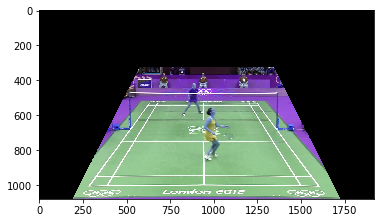

In [65]:
# read image
img = cv2.imread('../data/youtube/img_08339.png')
# select detection area
img, mask = select_region(img)
# inference
poses, scores = pose_detector(img) # posesはscoreが高い順
plt.imshow(img)
print(poses[0])

## poses, scores = pose_detector.detect_precise(img_pre)

[[ 893.  436.    2.]
 [ 886.  457.    2.]
 [ 870.  458.    2.]
 [ 858.  480.    2.]
 [ 863.  498.    2.]
 [ 903.  455.    2.]
 [ 905.  481.    2.]
 [ 909.  499.    2.]
 [ 871.  508.    2.]
 [ 858.  551.    2.]
 [ 832.  586.    2.]
 [ 896.  508.    2.]
 [ 911.  544.    2.]
 [ 918.  576.    2.]
 [ 888.  433.    2.]
 [ 895.  432.    2.]
 [ 881.  436.    2.]
 [ 898.  435.    2.]]


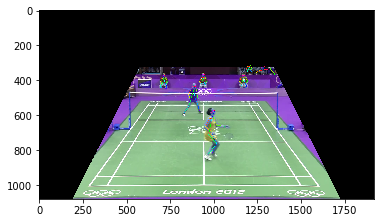

In [79]:
img_pre = cv2.imread('../data/youtube/img_08339.png')
img_pre, mask = select_region(img_pre)

# res_img = cv2.addWeighted(img, 0.6, draw_person_pose(img, poses), 0.4, 0)
# draw keypoint
poses_pre, scores = pose_detector.detect_precise(img_pre) # posesはscoreが高い順
img_pre = draw_person_pose(img_pre, poses_pre)

plt.imshow(img_pre)
print(poses_pre[0])

In [71]:
abs(poses[0]-poses_pre[0])

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [84]:
def compute_limbs_length(joints): # limbs_len is something wrong
    limbs = []
    limbs_len = np.zeros(len(params["limbs_point"])) # 19 points
    for i, joint_indices in enumerate(params["limbs_point"]):
        if joints[joint_indices[0]] is not None and joints[joint_indices[1]] is not None: # 鼻or首があるか確認する
            limbs.append([joints[joint_indices[0]], joints[joint_indices[1]]])
            limbs_len[i] = np.linalg.norm(joints[joint_indices[1]][:-1] - joints[joint_indices[0]][:-1])
        else:
            limbs.append(None)

    return limbs_len, limbs

def compute_unit_length(limbs_len): # 鼻首の長さを優先しない
    unit_length = 0
    base_limbs_len = limbs_len[[3, 0, 13, 9]] # (首左腰、首右腰、肩左耳、肩右耳)の長さの比率(このどれかが存在すればこれを優先的に単位長さの計算する)
    non_zero_limbs_len = base_limbs_len > 0
    if len(np.nonzero(non_zero_limbs_len)[0]) > 0:
        limbs_len_ratio = np.array([2.2, 2.2, 0.85, 0.85])
        unit_length = np.sum(base_limbs_len[non_zero_limbs_len] / limbs_len_ratio[non_zero_limbs_len]) / len(np.nonzero(non_zero_limbs_len)[0])
    else:
        limbs_len_ratio = np.array([2.2, 1.7, 1.7, 2.2, 1.7, 1.7, 0.6, 0.93, 0.65, 0.85, 0.6, 0.93, 0.65, 0.85, 1, 0.2, 0.2, 0.25, 0.25]) # 鼻首を1としている
        non_zero_limbs_len = limbs_len > 0
        unit_length = np.sum(limbs_len[non_zero_limbs_len] / limbs_len_ratio[non_zero_limbs_len]) / len(np.nonzero(non_zero_limbs_len)[0])

    return unit_length

def get_unit_length(person_pose):
    limbs_length, limbs = compute_limbs_length(person_pose)
    unit_length = compute_unit_length(limbs_length)

    return unit_length, limbs_length


In [68]:
# define crop person
def crop_person(img, person_pose, unit_length):
    top_joint_priority = [4, 5, 6, 12, 16, 7, 13, 17, 8, 10, 14, 9, 11, 15, 2, 3, 0, 1, sys.maxsize]
    bottom_joint_priority = [9, 6, 7, 14, 16, 8, 15, 17, 4, 2, 0, 5, 3, 1, 10, 11, 12, 13, sys.maxsize]

    top_joint_index = len(top_joint_priority) - 1
    bottom_joint_index = len(bottom_joint_priority) - 1
    left_joint_index = 0
    right_joint_index = 0
    top_pos = sys.maxsize
    bottom_pos = 0
    left_pos = sys.maxsize
    right_pos = 0

    for i, joint in enumerate(person_pose):
        if joint[2] > 0:
            if top_joint_priority[i] < top_joint_priority[top_joint_index]:
                top_joint_index = i
            elif bottom_joint_priority[i] < bottom_joint_priority[bottom_joint_index]:
                bottom_joint_index = i
            if joint[1] < top_pos:
                top_pos = joint[1]
            elif joint[1] > bottom_pos:
                bottom_pos = joint[1]

            if joint[0] < left_pos:
                left_pos = joint[0]
                left_joint_index = i
            elif joint[0] > right_pos:
                right_pos = joint[0]
                right_joint_index = i

    top_padding_ratio = [0.9, 1.9, 1.9, 2.9, 3.7, 1.9, 2.9, 3.7, 4.0, 5.5, 7.0, 4.0, 5.5, 7.0, 0.7, 0.8, 0.7, 0.8]
    bottom_padding_ratio = [6.9, 5.9, 5.9, 4.9, 4.1, 5.9, 4.9, 4.1, 3.8, 2.3, 0.8, 3.8, 2.3, 0.8, 7.1, 7.0, 7.1, 7.0]

    left = (left_pos - 0.3 * unit_length).astype(int)
    right = (right_pos + 0.3 * unit_length).astype(int)
    top = (top_pos - top_padding_ratio[top_joint_index] * unit_length).astype(int)
    bottom = (bottom_pos + bottom_padding_ratio[bottom_joint_index] * unit_length).astype(int)
    bbox = (left, top, right, bottom)

    cropped_img = pose_detector.crop_image(img, bbox)
    return cropped_img, bbox

## 審判の顔を検出してしまっている..

## poses

25.2444647093


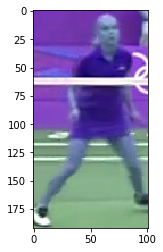

In [74]:
# detect bottom player(0:bottom, 1:top player)
unit_0, limbs_len = get_unit_length(poses[0])
print(unit_0)
cropped_img_b, bbox_b = crop_person(img, poses[0], unit_0) 
if cropped_img_b is not None:
    crop_img_b = img[bbox_b[1]:bbox_b[3], bbox_b[0]:bbox_b[2]] #bbox=(x_lefttop,y)
    plt.imshow(crop_img_b)

## poses_pre

377.484268333
[   95.35197953    67.35725648    82.61961026    91.04943712    60.8276253
    59.94163828    12.04159458    51.88448708    48.27007354    36.40054945
    11.04536102    46.5188134     43.28972164  1175.02723373    45.69463864
     7.28010989     7.61577311    16.40121947  1152.53156139]


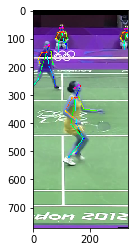

In [85]:
# detect bottom player(0:bottom, 1:top player)
unit_pre_0, limbs_len_pre = get_unit_length(poses_pre[1])
print(unit_pre_0)
print(limbs_len_pre)
cropped_img, bbox = crop_person(img_pre, poses_pre[1], unit_pre_0) 
if cropped_img is not None:
    crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
    plt.imshow(crop_img)

# multi images

In [15]:
# read multi images
for i in range(0,61):    
    print('83{0:02d}'.format(i))
    # read image
    img = cv2.imread('../data/youtube/img_083{0:02d}.png'.format(i))
    # select detection area
    img, mask = select_region(img)
    # inference
    poses, scores = pose_detector(img) # posesはscoreが高い順
    # draw keypoint
    img = draw_person_pose(img, poses)
    # plt.imshow(img)
    
    # compare unit_length 
    unit_0 = get_unit_length(poses[0])
    unit_1 = get_unit_length(poses[1])
    print(unit_1)
    if (unit_1 > 100):
        print(i)
        break
    # detect bottom player(0:bottom, 1:top player)
    cropped_img_b, bbox_b = crop_person(img, poses[0], unit_0) 
    if cropped_img_b is not None:
        crop_img_b = img[bbox_b[1]:bbox_b[3], bbox_b[0]:bbox_b[2]] #bbox=(x_lefttop,y)
        cv2.imwrite('../data/0/crop_{:d}.png'.format(i), crop_img_b)

    # detect top player
    cropped_img, bbox = crop_person(img, poses[1], unit_1) 
    if cropped_img is not None:
        crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
        cv2.imwrite('../data/1/crop_{:d}.png'.format(i), crop_img)

8300
23.1604041602
8301
22.8886976893
8302
22.7768242437
8303
23.3837262799
8304
23.0123025444
8305
23.8046210198
8306
23.8102025666
8307
24.1815382659
8308
23.3440314045
8309
23.6728515044
8310
23.9763472108
8311
24.8892989568
8312
24.5155856087
8313
24.0412436339
8314
24.1446919293
8315
23.448303899
8316
22.7705782326
8317
22.985473912
8318
22.2795599226
8319
23.0119738999
8320
22.9951745644
8321
23.410459384
8322
22.2508998772
8323
24.3489835384
8324
24.8253212601
8325
24.0743849765
8326
24.7657991346
8327
25.1410389542
8328
26.3954220573
8329
27.2214471172
8330
27.2774241212
8331
26.1193110958
8332
25.3058630592
8333
25.6212625673
8334
25.2575851421
8335
26.1699147211
8336
25.4435723141
8337
24.8241934983
8338
24.8139654057
8339
377.484268333


In [ ]:
if (unit_0 > unit_1): # (larger=bottom)
        # detect bottom player(0:bottom, 1:top player)
        cropped_img_b, bbox_b = pose_detector.crop_person(img, poses[0], unit_0) 
        if cropped_img_b is not None:
            crop_img_b = img[bbox_b[1]:bbox_b[3], bbox_b[0]:bbox_b[2]] #bbox=(x_lefttop,y)
            cv2.imwrite('./data/0/crop_{:d}.png'.format(i), crop_img_b)
        
        # detect top player
        cropped_img, bbox = pose_detector.crop_person(img, poses[1], unit_1) 
        if cropped_img is not None:
            crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
            cv2.imwrite('./data/1/crop_{:d}.png'.format(i), crop_img)
    else:
        print('detect bottom player failed.')    


In [ ]:
# detect bottom player(0:bottom, 1:top player)
cropped_img_b, bbox_b = pose_detector.crop_person(img, poses[0], unit_0) 
if cropped_img_b is not None:
    crop_img_b = img[bbox_b[1]:bbox_b[3], bbox_b[0]:bbox_b[2]] #bbox=(x_lefttop,y)
    cv2.imwrite('./data/0/crop_{:d}.png'.format(i), crop_img_b)

# detect top player
cropped_img, bbox = pose_detector.crop_person(img, poses[1], unit_1) 
if cropped_img is not None:
    crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
    cv2.imwrite('./data/1/crop_{:d}.png'.format(i), crop_img)

In [24]:
num_person = poses.shape[0]
# each person detected
for i, pose in enumerate(poses):
    unit_length = pose_detector.get_unit_length(pose)
    # detect person
    cropped_person_img, bbox = pose_detector.crop_person(img, pose, unit_length) 
    #if cropped_person_img is not None:
    #    crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
     #   plt.imshow(crop_img)
        

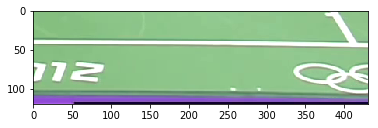

In [25]:
crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
plt.imshow(crop_img)

(744, 131, 1178, 1253)
568.504843645
1122


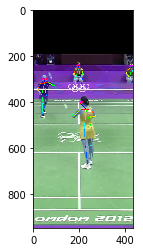

In [27]:
i = 0
# detect person
cropped_person_img, bbox = pose_detector.crop_person(img, poses[i], unit_length) 
if cropped_person_img is not None:
    # cv2.rectangle(res_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), 1)
    print(bbox)
    print(unit_length)
    if (bbox[3]-bbox[1] > 120):
        crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
        plt.imshow(crop_img)
        print(bbox[3] - bbox[1])
    else:
        print(bbox[3] - bbox[1])

<class 'numpy.ndarray'>


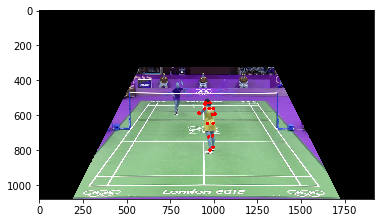

In [11]:
img = cv2.imread('./data/youtube/img_08304.png')
img, mask = select_region(img)
plt.imshow(img)
i = 0
unit_length = pose_detector.get_unit_length(poses[i])
print(type(poses[i]))
for i, pose in enumerate(poses[i].astype(int)):
    img = cv2.circle(img, tuple(pose[0:2]), 10, (255, 0, 0), -1)
plt.imshow(img)

In [1]:
pose = poses[0]
pose[0:2]

NameError: name 'poses' is not defined

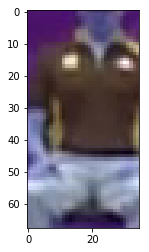

In [82]:
# each person detected
for i, person_pose in enumerate(person_pose_array):
    unit_length = pose_detector.get_unit_length(person_pose)
    # detect person
    cropped_person_img, bbox = pose_detector.crop_person(img, person_pose, unit_length) 
    if cropped_person_img is not None:
         #cv2.rectangle(res_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 255, 255), 1)
            crop_img = img[bbox[1]:bbox[3], bbox[0]:bbox[2]] #bbox=(x_lefttop,y)
            plt.imshow(crop_img)
            cv2.imwrite('./data/crop_{0:02d}.png'.format(i), crop_img)